<a href="https://colab.research.google.com/github/venkyy23/chlorhexidine-survival-analysis/blob/main/Chlorhexidine_Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📘 Chlorhexidine Trial Survival Analysis**
**Using Kaplan–Meier, Log-Rank Test, Cox PH Model, Nelson–Aalen, Forest Plot, Event Distribution**

# ⭐ Cell 1 Setup and Library Installation

In [23]:
!pip install lifelines


# ⭐ Cell 2 Imports and File Path Setup

In [5]:
# Cell 2  Imports and file path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events

# display helpers in notebooks
from IPython.display import display

# File path to your Excel dataset
DATA_PATH = "/content/Chlorhexidine Trials.xlsx"  # update if different


# ⭐ Cell 3 Load Dataset and Quick Overview

In [6]:
# Cell 3  Load dataset and quick overview
df = pd.read_excel(DATA_PATH)
print("Rows Columns:", df.shape)
display(df.head(7))
print("\nColumn dtypes:\n", df.dtypes)


Rows Columns: (106, 8)


,TrialArm,Age,Gender,Outcome of the current episode,event,APACHE II Score,TLC Day 1,time
0,1,49,Male,No VAP,0,11,11900,5
1,1,72,Male,No VAP,0,17,16800,6
2,1,72,Male,No VAP,0,16,23300,8
3,1,55,Female,No VAP,0,29,9500,10
4,1,20,Male,No VAP,0,18,7000,6
5,1,24,Male,No VAP,0,5,18600,10
6,1,36,Male,No VAP,0,19,14400,3



Column dtypes:
 TrialArm                           int64
Age                                int64
Gender                            object
Outcome of the current episode    object
event                              int64
APACHE II Score                    int64
TLC Day 1                          int64
time                               int64
dtype: object


# ⭐ Cell 4 Data Cleaning, Encoding and Preprocessing

In [7]:
# Cell 4  Data cleaning and encoding utilities
# Everything is done on a copy to avoid accidental mutation of original data
df = df.copy()

# Safe rename map
rename_map = {
    'APACHE II Score': 'APACHEII',
    'TLC Day 1': 'TLC_D1',
}
df.rename(columns=rename_map, inplace=True)

# Ensure time and event are numeric and present
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['event'] = pd.to_numeric(df['event'], errors='coerce').astype('Int64')

# TrialArm numeric encoding
if 'TrialArm' in df.columns:
    if df['TrialArm'].dtype == object:
        try:
            df['TrialArm_num'] = pd.to_numeric(df['TrialArm'])
        except:
            df['TrialArm_num'] = df['TrialArm'].map({'Group 1':1, 'Group 2':2}).astype('Int64')
    else:
        df['TrialArm_num'] = df['TrialArm'].astype('Int64')
else:
    raise ValueError("TrialArm column missing")

# Gender encoding: binary if Male Female else one hot
if 'Gender' in df.columns:
    gender_unique = df['Gender'].dropna().unique().tolist()
    if set(gender_unique).issubset({'Male','Female'}):
        df['Gender_binary'] = df['Gender'].map({'Male':1,'Female':0}).astype('Int64')
    else:
        dummies = pd.get_dummies(df['Gender'], prefix='Gender', drop_first=True)
        df = pd.concat([df, dummies], axis=1)

# Final checks for essential columns
essential = ['time','event','Age','APACHEII','TLC_D1','TrialArm_num']
missing_ess = [c for c in essential if c not in df.columns]
if missing_ess:
    raise ValueError(f"Missing required columns: {missing_ess}")

print("Any NA in time/event? ", df['time'].isna().any(), df['event'].isna().any())
display(df[ ['time','event','Age','APACHEII','TLC_D1','TrialArm_num'] ].head())



Any NA in time/event?  False False


,time,event,Age,APACHEII,TLC_D1,TrialArm_num
0,5,0,49,11,11900,1
1,6,0,72,17,16800,1
2,8,0,72,16,23300,1
3,10,0,55,29,9500,1
4,6,0,20,18,7000,1


# ⭐ Cell 5 Baseline Summary Statistics

In [8]:
# Cell 5  Baseline summary statistics
baseline_table = {
    "N": [len(df)],
    "Events VAP": [int(df['event'].sum())],
    "Age mean SD": [f"{df['Age'].mean():.1f} ({df['Age'].std():.1f})"],
    "APACHEII mean SD": [f"{df['APACHEII'].mean():.1f} ({df['APACHEII'].std():.1f})"],
    "TLC Day1 mean SD": [f"{df['TLC_D1'].mean():.0f} ({df['TLC_D1'].std():.0f})"],
    "Arm1 n": [int((df['TrialArm_num']==1).sum())],
    "Arm2 n": [int((df['TrialArm_num']==2).sum())],
    "Male n": [int((df['Gender']=='Male').sum()) if 'Gender' in df.columns else None],
    "Female n": [int((df['Gender']=='Female').sum()) if 'Gender' in df.columns else None],
    "Time mean SD": [f"{df['time'].mean():.1f} ({df['time'].std():.1f})"]
}
baseline_df = pd.DataFrame(baseline_table).T.rename(columns={0:"Value"})
display(baseline_df)


,Value
N,106
Events VAP,10
Age mean SD,47.6 (17.3)
APACHEII mean SD,16.9 (6.5)
TLC Day1 mean SD,15216 (7270)
Arm1 n,61
Arm2 n,45
Male n,93
Female n,13
Time mean SD,5.7 (2.4)


# ⭐ Cell 6 Exploratory Visualizations



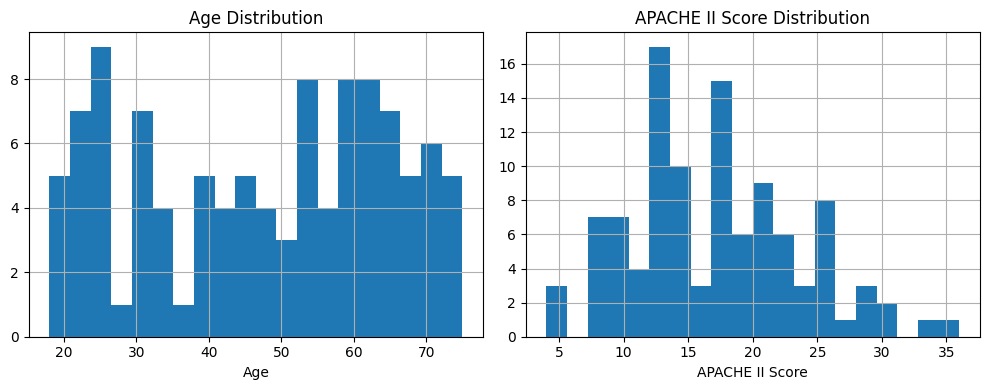

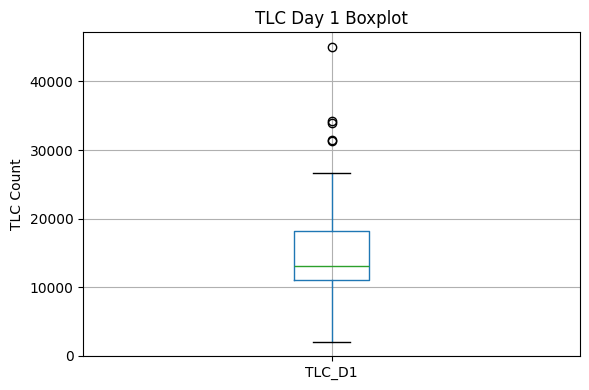

In [9]:
# Cell 6  Visualizations histograms and boxplots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df['Age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')

plt.subplot(1,2,2)
df['APACHEII'].hist(bins=20)
plt.title('APACHE II Score Distribution')
plt.xlabel('APACHE II Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df.boxplot(column=['TLC_D1'])
plt.title('TLC Day 1 Boxplot')
plt.ylabel('TLC Count')
plt.tight_layout()
plt.show()


# ⭐ Cell 7 KM Utilities and Pre-Fitted KM Objects

In [10]:
# Cell 7  Utilities to reduce redundancy
# Group masks and store per arm dataframes and fitted KM objects to reuse
arms = sorted(df['TrialArm_num'].unique())
arm_dfs = {a: df[df['TrialArm_num']==a].copy() for a in arms}

# Storage for fitted objects
kmf_by_arm = {}
for a, adf in arm_dfs.items():
    km = KaplanMeierFitter()
    km.fit(adf['time'], adf['event'], label=f"Arm {int(a)}")
    kmf_by_arm[a] = km

# Overall KM
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(df['time'], df['event'], label='Overall VAP free survival')


<lifelines.KaplanMeierFitter:"Overall VAP free survival", fitted with 106 total observations, 96 right-censored observations>

# ⭐ Cell 8 Life Tables (Overall and Per Arm)

In [11]:
# Cell 8  Life tables overall and per arm (saved)
life_table_overall = survival_table_from_events(df['time'], df['event'])
display(life_table_overall.head(20))
life_table_overall.to_csv("life_table_overall.csv", index=True)

per_arm_tables = {}
for a, adf in arm_dfs.items():
    lt = survival_table_from_events(adf['time'], adf['event'])
    per_arm_tables[a] = lt
    print(f"Life table Arm {int(a)} n={len(adf)}")
    display(lt.head(10))
    lt.to_csv(f"life_table_arm_{int(a)}.csv", index=True)


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,106,106
1.0,3,1,2,0,106
2.0,6,0,6,0,103
3.0,8,4,4,0,97
4.0,15,0,15,0,89
5.0,21,3,18,0,74
6.0,22,0,22,0,53
7.0,8,0,8,0,31
8.0,7,0,7,0,23


Life table Arm 1 n=61


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,61,61
1.0,2,1,1,0,61
2.0,3,0,3,0,59
3.0,2,0,2,0,56
4.0,8,0,8,0,54
5.0,16,3,13,0,46
6.0,10,0,10,0,30
7.0,6,0,6,0,20
8.0,5,0,5,0,14


Life table Arm 2 n=45


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,45,45
1.0,1,0,1,0,45
2.0,3,0,3,0,44
3.0,6,4,2,0,41
4.0,7,0,7,0,35
5.0,5,0,5,0,28
6.0,12,0,12,0,23
7.0,2,0,2,0,11
8.0,2,0,2,0,9


# **⭐ Cell 9 Kaplan–Meier Plots**
1.   Overall KM
2.   KM by treatment arm

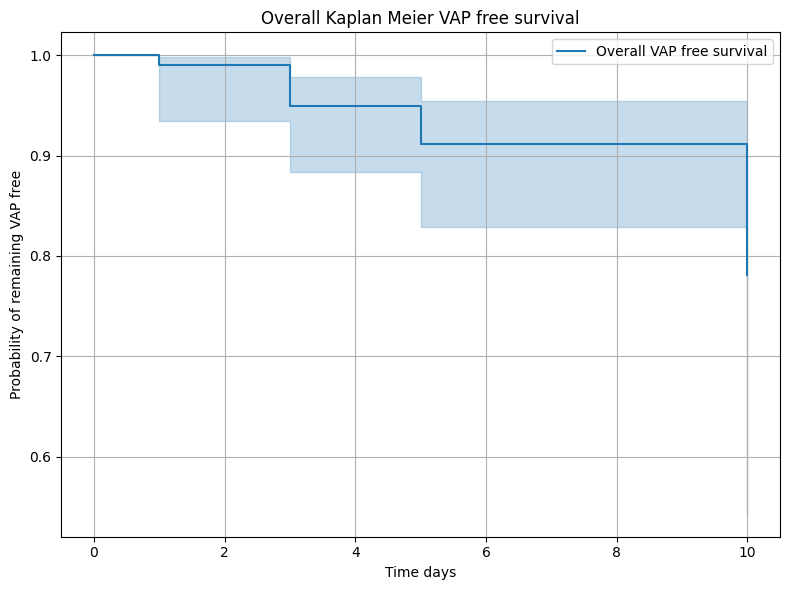

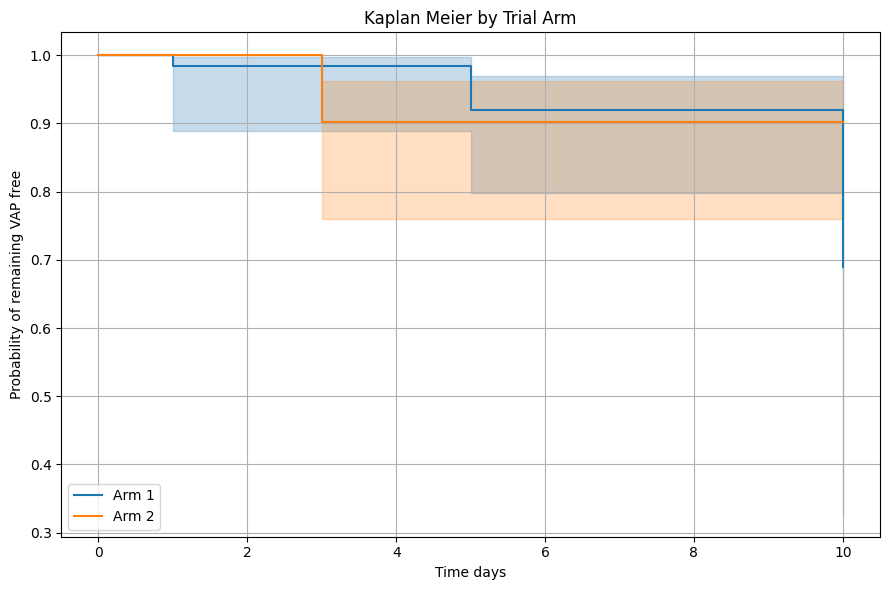

In [22]:
# Cell 9  Kaplan Meier plots overall and by arm
plt.figure(figsize=(8,6))
kmf_overall.plot(ci_show=True)
plt.title("Overall Kaplan Meier VAP free survival")
plt.xlabel("Time days")
plt.ylabel("Probability of remaining VAP free")
plt.grid(True)
plt.tight_layout()
plt.show()

# By arm
plt.figure(figsize=(9,6))
for a, km in kmf_by_arm.items():
    km.plot_survival_function(ci_show=True)
plt.title("Kaplan Meier by Trial Arm")
plt.xlabel("Time days")
plt.ylabel("Probability of remaining VAP free")
plt.grid(True)
plt.tight_layout()
plt.show()

# **⭐ Cell 10 Median Survival and Survival Probabilities (Reusable Function)**

1.   Survival at Day 5
2.   KM summary table



In [13]:
# Cell 10  Median survival and survival probabilities function
def summarize_km(km_obj, times = [5]):
    median = km_obj.median_survival_time_
    surv_at = {t: float(km_obj.survival_function_at_times(t).iloc[0]) if t in km_obj.survival_function_.index else np.nan for t in times}
    return {"median": median, **{f"surv_{t}": surv_at[t] for t in times}}

print("Overall summary:", summarize_km(kmf_overall, times=[5]))

km_table_rows = []
for a, km in kmf_by_arm.items():
    s = summarize_km(km, times=[5])
    adf = arm_dfs[a]
    km_table_rows.append({
        "TrialArm": int(a),
        "N": len(adf),
        "Events": int(adf['event'].sum()),
        "Median_time": s['median'],
        "Survival_Day5": np.round(s['surv_5'],3) if not np.isnan(s['surv_5']) else np.nan
    })
km_table = pd.DataFrame(km_table_rows)
display(km_table)
km_table.to_csv("km_table.csv", index=False)


Overall summary: {'median': np.float64(inf), 'surv_5': 0.9112158745012274}


,TrialArm,N,Events,Median_time,Survival_Day5
0,1,61,6,inf,0.919
1,2,45,4,inf,0.902


# ⭐ Cell 11 Log-Rank Test (Between Arms)

In [14]:
# Cell 11  Log rank test between arms
if len(arms)==2:
    g1 = arm_dfs[arms[0]]
    g2 = arm_dfs[arms[1]]
    lr = logrank_test(g1['time'], g2['time'], event_observed_A=g1['event'], event_observed_B=g2['event'])
    print("Log rank test pvalue:", lr.p_value)
    lr.print_summary()
else:
    print("Log rank requires exactly two arms. Found arms:", arms)


Log rank test pvalue: 0.9438198841889167


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.94      0.08

# ⭐ Cell 12 Prepare Data for Cox Regression

In [15]:
# Cell 12  Prepare data for Cox regression modularly
model_cols = ['time','event','Age','APACHEII','TLC_D1','TrialArm_num']
# include gender if present
if 'Gender_binary' in df.columns:
    model_cols.append('Gender_binary')
else:
    gender_dummy_cols = [c for c in df.columns if c.startswith('Gender_')]
    model_cols += gender_dummy_cols

missing = [c for c in model_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing model cols: {missing}")

cox_data = df[model_cols].copy()

# convert predictors to numeric and impute median if needed
for c in cox_data.columns:
    if c in ['time','event']:
        if cox_data[c].isna().any():
            raise ValueError(f"Column {c} contains missing values; fix before modeling.")
        continue
    cox_data[c] = pd.to_numeric(cox_data[c], errors='coerce')
    if cox_data[c].isna().any():
        med = cox_data[c].median()
        cox_data[c].fillna(med, inplace=True)
        print(f"Imputed {c} with median {med}")

display(cox_data.describe().T)
cox_data.to_csv("cox_data_check.csv", index=False)


,count,mean,std,min,25%,50%,75%,max
time,106.0,5.716981,2.377493,1.0,4.0,5.5,7.0,10.0
event,106.0,0.09434,0.293689,0.0,0.0,0.0,0.0,1.0
Age,106.0,47.59434,17.319286,18.0,32.0,50.0,62.0,75.0
APACHEII,106.0,16.933962,6.532365,4.0,12.0,17.0,21.0,36.0
TLC_D1,106.0,15216.037736,7269.677884,2100.0,11100.0,13100.0,18150.0,45000.0
TrialArm_num,106.0,1.424528,0.496619,1.0,1.0,1.0,2.0,2.0
Gender_binary,106.0,0.877358,0.329584,0.0,1.0,1.0,1.0,1.0


# ⭐ Cell 13 Fit Cox Proportional Hazards Model

Save summary as CSV

In [16]:
# Cell 13  Fit Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time', event_col='event')
print("Cox PH summary:")
cph.print_summary()
cph.summary.to_csv("cox_summary.csv", index=True)


Cox PH summary:


<lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 10
   partial log-likelihood = -39.97
         time fit was run = 2025-11-23 16:23:14 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age           -0.01      0.99      0.02           -0.05            0.02                0.95                1.02
APACHEII      -0.04      0.97      0.05           -0.13            0.06                0.88                1.06
TLC_D1        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TrialArm_num  -0.03      0.97      0.71           -1.42            1.36                0.24                3.89
Gender_binary  0.64      1.90      1.13           -1.57            2.85                0.21               17.24

               cmp to     z    p  -log2(p)
covariate                                 
Age              0.00 -0.71 0.48      1.06
APACHEII         0.00 -0.73 0.47      1.10
TLC_D1           0.00 -0.58 0.56      0.83
TrialArm_num     0.00 -0.04 0.97      0.05
Gender_binary    0.00  0.57 0.57      0.81
---
Concordance = 0.59
Partial AIC = 89.94
log-likelihood ratio test = 2.01 on 5 df
-log2(p) of ll-ratio test = 0.24

# ⭐ Cell 14 Check Proportional Hazards Assumptions

Schoenfeld residuals plots and diagnostics


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic    p  -log2(p)
APACHEII      km              0.01 0.91      0.14
              rank            0.04 0.85      0.23
Age           km              0.00 0.97      0.04
              rank            0.00 0.94      0.08
Gender_binary km              1.29 0.26      1.96
              rank            0.00 0.97      0.05
TLC_D1        km              0.61 0.44      1.20
              rank            0.50 0.48      1.06
TrialArm_num  km              3.72 0.05      4.21
              rank            2.90 0.09      3.50



1. Variable 'TrialArm_num' failed the non-proportional test: p-value is 0.0539.

   Advice: with so few unique values (only 2), you can include `strata=['TrialArm_num', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.67239e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[[<Axes: xlabel='rank-transformed time\n(p=0.9445)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9694)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8503)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9057)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4799)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4350)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0886)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0539)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9653)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2566)'>]]

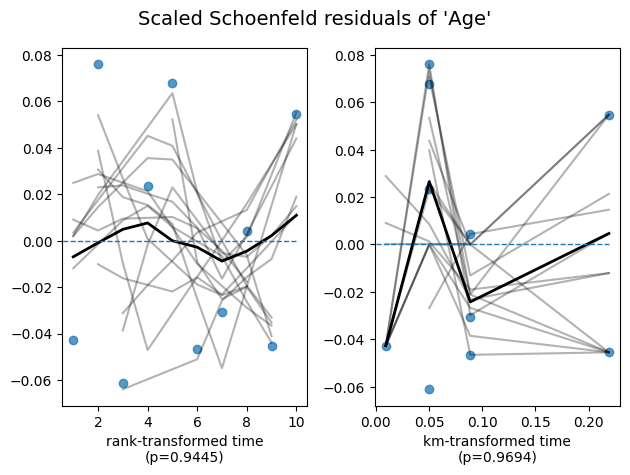

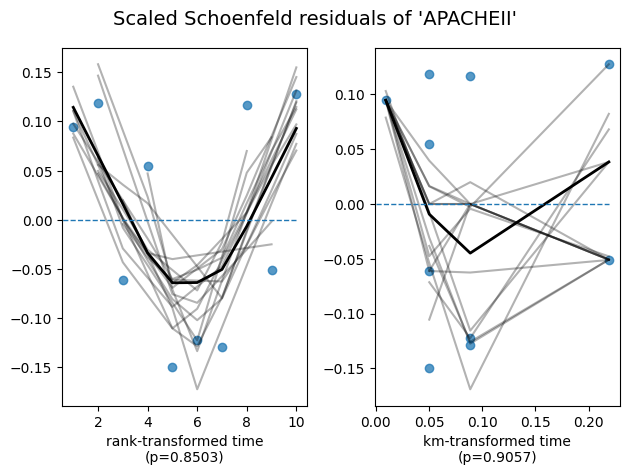

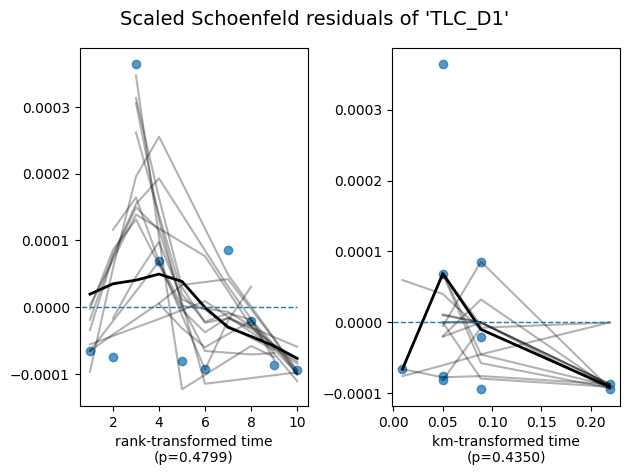

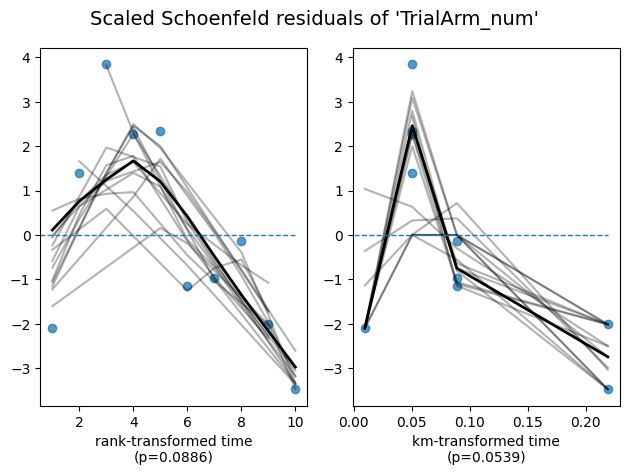

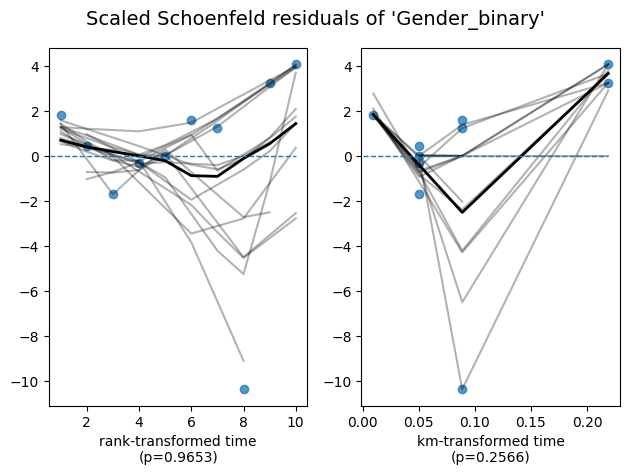

In [17]:
# Cell 14  Proportional hazards check
# This will produce plots and a console summary
cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=True)


# ⭐ Cell 15 Forest Plot for Hazard Ratios (HR + 95% CI)


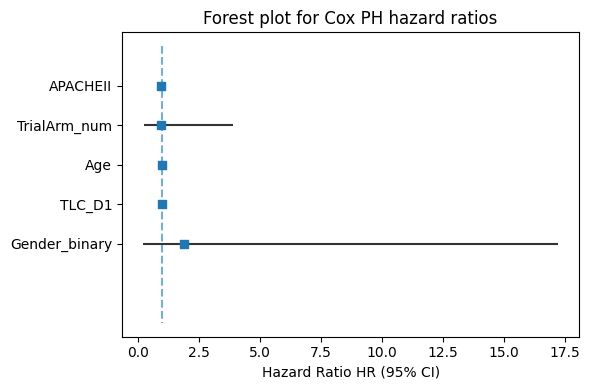

In [18]:
# Cell 15  Forest plot for hazard ratios with CI
# Create a publication style forest plot showing HR and 95 CI for each covariate
summary = cph.summary.reset_index()
summary['HR'] = summary['exp(coef)']
summary['HR_lower'] = summary['exp(coef) lower 95%']
summary['HR_upper'] = summary['exp(coef) upper 95%']

# Sort for nicer plot
summary = summary.sort_values(by='HR')

plt.figure(figsize=(6, 0.6*len(summary)+1))
y_pos = np.arange(len(summary))
plt.hlines(y_pos, summary['HR_lower'], summary['HR_upper'], color='black', alpha=0.8)
plt.scatter(summary['HR'], y_pos, marker='s', s=40, zorder=3)
plt.vlines(1, -1, len(summary)+1, linestyles='dashed', alpha=0.6)
plt.yticks(y_pos, summary['covariate'])
plt.xlabel('Hazard Ratio HR (95% CI)')
plt.gca().invert_yaxis()
plt.title('Forest plot for Cox PH hazard ratios')
plt.tight_layout()
plt.savefig("forest_plot_hr_ci.png", dpi=300)
plt.show()


# **⭐ Cell 16 Nelson–Aalen Cumulative Hazard Plots**


1.   Overall
2.   By treatment arm





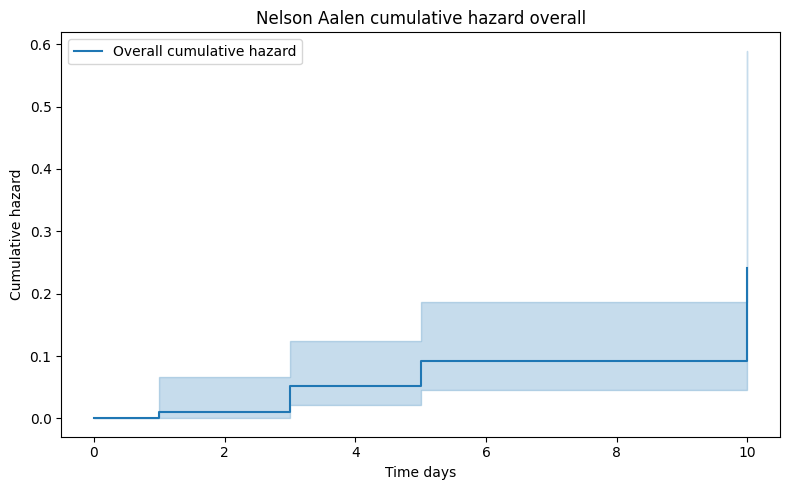

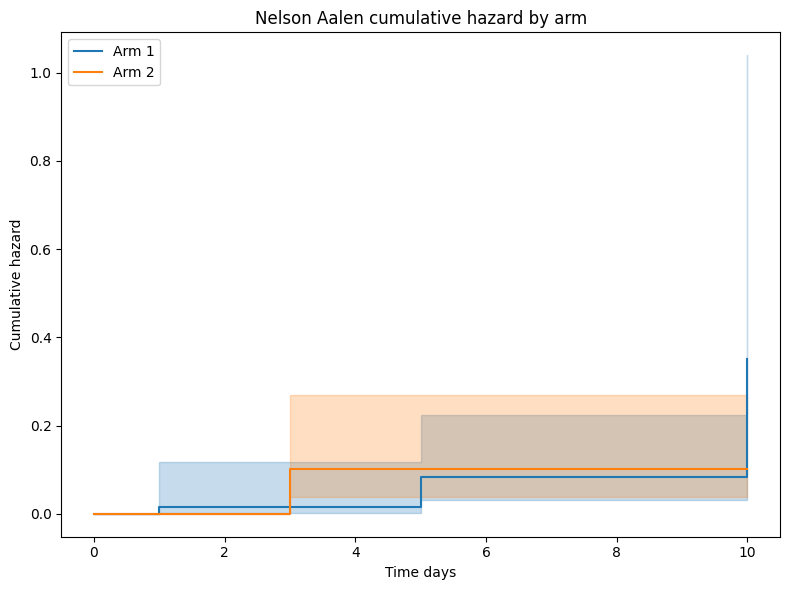

In [19]:
# Cell 16  Nelson Aalen cumulative hazard plots
naf_overall = NelsonAalenFitter()
naf_overall.fit(df['time'], df['event'], label='Overall cumulative hazard')
plt.figure(figsize=(8,5))
naf_overall.plot()
plt.title('Nelson Aalen cumulative hazard overall')
plt.xlabel('Time days')
plt.ylabel('Cumulative hazard')
plt.tight_layout()
plt.show()

# By arm
plt.figure(figsize=(8,6))
for a, adf in arm_dfs.items():
    naf = NelsonAalenFitter()
    naf.fit(adf['time'], adf['event'], label=f"Arm {int(a)}")
    naf.plot()
plt.title('Nelson Aalen cumulative hazard by arm')
plt.xlabel('Time days')
plt.ylabel('Cumulative hazard')
plt.tight_layout()
plt.show()



# **⭐ Cell 17 Event Distribution Bar Charts**


1.   Events vs censored
2.   Arm-wise event distribution




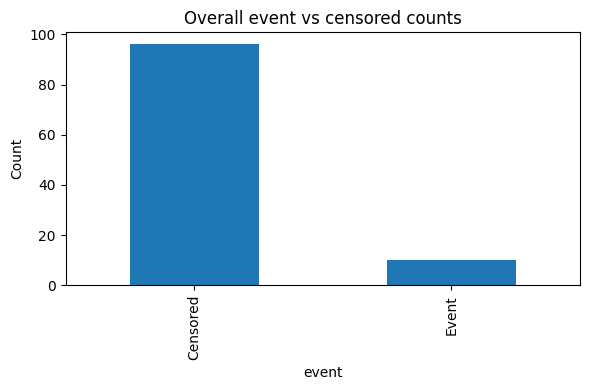

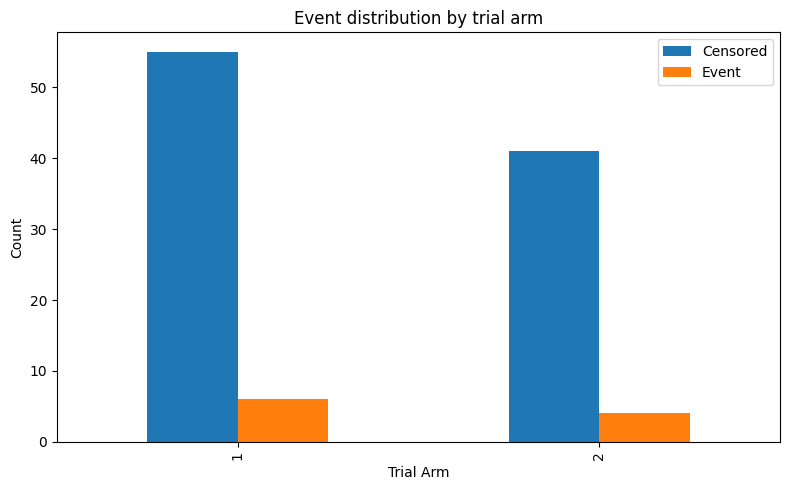

In [20]:
# Cell 17  Event distribution bar charts
# Overall event vs censored
event_counts = df['event'].value_counts().rename(index={1:'Event', 0:'Censored'})
plt.figure(figsize=(6,4))
event_counts.plot(kind='bar')
plt.title('Overall event vs censored counts')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Arm wise event counts
arm_event = df.groupby(['TrialArm_num','event']).size().unstack(fill_value=0)
arm_event.columns = ['Censored' if c==0 else 'Event' for c in arm_event.columns]
arm_event.plot(kind='bar', stacked=False, figsize=(8,5))
plt.title('Event distribution by trial arm')
plt.xlabel('Trial Arm')
plt.ylabel('Count')
plt.legend(title='')
plt.tight_layout()
plt.show()


# ⭐ Cell 18 Final Tables for Report (KM Table and Cox Table)

In [21]:
# Cell 18  Final tables for report insertion and save CSVs
# KM table is already saved. Prepare cox tidy table
cox_table = cph.summary.reset_index()[['covariate','exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
cox_table.columns = ['Variable','HR','Lower95','Upper95','p_value']
display(km_table)
display(cox_table)
km_table.to_csv("km_table.csv", index=False)
cox_table.to_csv("cox_table.csv", index=False)
print("Saved km_table.csv and cox_table.csv")


,TrialArm,N,Events,Median_time,Survival_Day5
0,1,61,6,inf,0.919
1,2,45,4,inf,0.902


,Variable,HR,Lower95,Upper95,p_value
0,Age,0.986361,0.949488,1.024666,0.479896
1,APACHEII,0.965321,0.877559,1.061861,0.467998
2,TLC_D1,0.999968,0.999861,1.000075,0.561931
3,TrialArm_num,0.971059,0.242103,3.894859,0.966946
4,Gender_binary,1.897335,0.208851,17.236556,0.569444


Saved km_table.csv and cox_table.csv


# ⭐ Cell 19 Save KM Objects

In [ ]:
# Cell 19  Optional saves and reproducibility notes
# Save fitted KM and Nelson Aalen objects using pickle if desired
import pickle
with open("kmf_overall.pkl", "wb") as f:
    pickle.dump(kmf_overall, f)
for a, km in kmf_by_arm.items():
    with open(f"kmf_arm_{int(a)}.pkl", "wb") as f:
        pickle.dump(km, f)
print("Saved pickle files for KM objects")
